#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> WaveNet - Stock Market Prediction

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow       as   tf
from   tensorflow     import keras
from keras.models     import Sequential
from keras.layers     import LSTM, Dropout, Dense, Activation, SimpleRNN, TimeDistributed
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Data

In [2]:
Project_Name = 'Google_Stock_Price'

data = pd.read_csv('Google_Stock_Price.csv')
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [3]:
sclr = 'Volume'
C = data[[sclr]].copy()
for i in range(C.shape[0]):  C.loc[i,sclr] = C.loc[i,sclr].replace(",","") 

In [4]:
TimeSeries         = C.astype(float)
TimeSeries.index   = pd.to_datetime( data['Date'].values, format='%m/%d/%Y')
TimeSeries.columns =     ['Series']
TimeSeries.tail(3)

,Series
2016-12-28,1153800.0
2016-12-29,744300.0
2016-12-30,1770000.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smooting Series & Noisy Seasonality

In [5]:
''' 
def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise
''' 

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

smoothed, noise = smoother( TimeSeries, 'Series', 20 )

TimeSeries[     'Noise'     ] = np.round( noise, 0 )  
TimeSeries['Smoothed_Series'] = np.round( smoothed, 0 ) 
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series
2016-12-28,1153800.0,-514206.0,1668006.0
2016-12-29,744300.0,-971462.0,1715762.0
2016-12-30,1770000.0,0.0,1770000.0


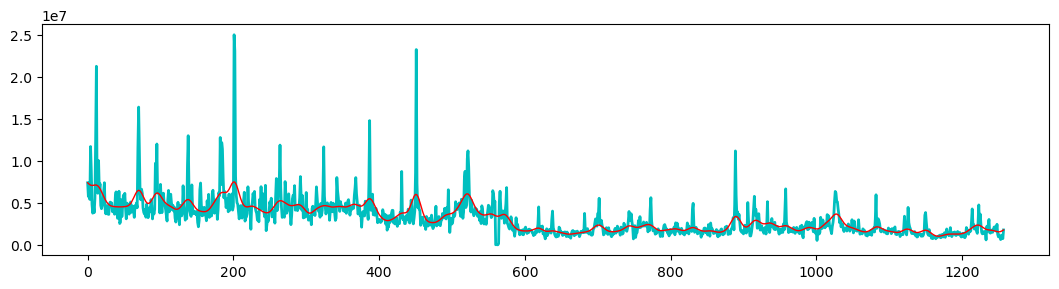

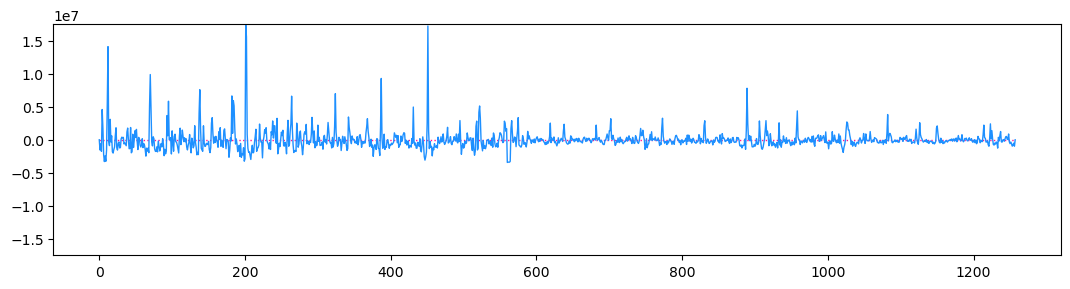

In [6]:
Range = range(TimeSeries.shape[0])
plt.figure(figsize=(12,3))
plt.plot(Range,TimeSeries['Series'],color='c',linewidth=2 ) 
plt.plot(Range,TimeSeries['Smoothed_Series'],color='r',linewidth=1) 
plt.show()

plt.figure(figsize=(12,3))
plt.plot( [Range[0],Range[-1]], [0,0], color='deeppink'  , linewidth=1, linestyle=':' )
plt.plot(  Range, TimeSeries['Noise'], color='dodgerblue', linewidth=1                ) 
mx=max(abs(TimeSeries['Noise']));plt.gca().set_ylim(-mx,+mx)
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend & Initial_Value & Residuals

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

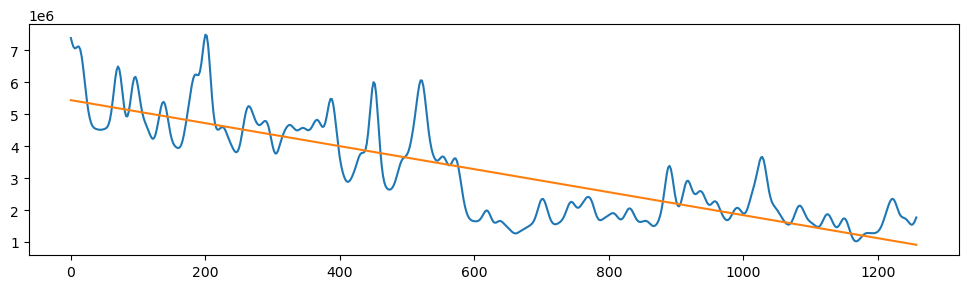

In [7]:
# Tend  
import numpy as np
from sklearn.linear_model import LinearRegression

T = pd.DataFrame( range( TimeSeries[ 'Smoothed_Series' ].shape[0] ))  
model = LinearRegression().fit( T, TimeSeries[['Smoothed_Series']] ) 

# trnd & initial values
trend         = model.coef_[0]     # slope
initial_value = model.intercept_   # intercept

# Trend
trend_line = trend*T + initial_value
TimeSeries['Trend'] = trend_line.values

# Plot
plt.figure(figsize=(12,3))
plt.plot( T, TimeSeries[['Smoothed_Series']] )
plt.plot( T, TimeSeries['Trend'] )
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic_Seasonality

In [8]:
#residual = y.values - trend_line.values
TimeSeries['Cyclic_Seasonality'] = TimeSeries['Smoothed_Series'] - TimeSeries['Trend']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality
2016-12-28,1153800.0,-514206.0,1668006.0,923216.503658,744789.496342
2016-12-29,744300.0,-971462.0,1715762.0,919618.434069,796143.565931
2016-12-30,1770000.0,0.0,1770000.0,916020.364480,853979.635520


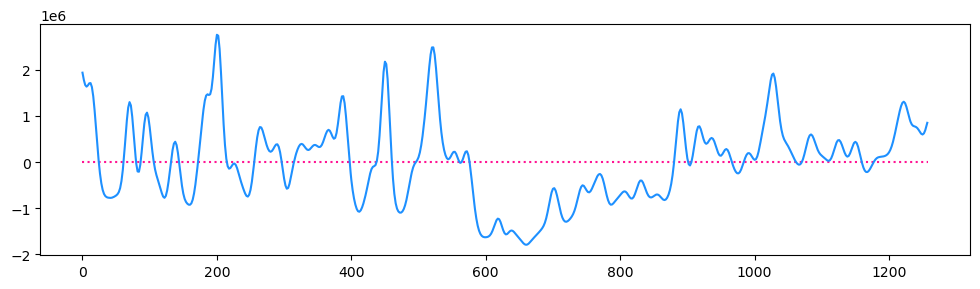

In [9]:
plt.figure( figsize=(12,3) )
plt.plot( [0,len(T)], [0,0], ':', color='deeppink' )
plt.plot( T, TimeSeries['Cyclic_Seasonality'], color='dodgerblue' )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Extracting Y, M, D from Dates

In [10]:
Dates = TimeSeries.index.date.tolist()
Dates[:3]

[datetime.date(2012, 1, 3),
 datetime.date(2012, 1, 4),
 datetime.date(2012, 1, 5)]

In [11]:
Dates = pd.to_datetime(Dates, format='%m/%d/%Y')
Dates[:3]

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05'], dtype='datetime64[ns]', freq=None)

In [12]:
df = pd.DataFrame()
df['Year' ] = Dates.year
df['month'] = Dates.month
df[ 'day' ] = Dates.day
df.index = Dates
df.sample(3)

,Year,month,day
2013-12-02,2013,12,2
2014-09-29,2014,9,29
2015-07-24,2015,7,24


In [13]:
Seasons = pd.concat([df,TimeSeries],axis=1) 
Seasons.tail(3)

,Year,month,day,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality
2016-12-28,2016,12,28,1153800.0,-514206.0,1668006.0,923216.503658,744789.496342
2016-12-29,2016,12,29,744300.0,-971462.0,1715762.0,919618.434069,796143.565931
2016-12-30,2016,12,30,1770000.0,0.0,1770000.0,916020.364480,853979.635520


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Visualizing Cyclic Seasonality

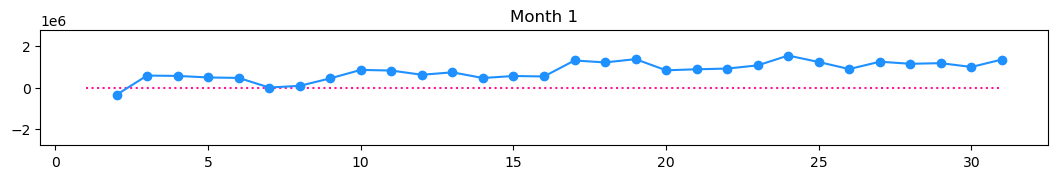

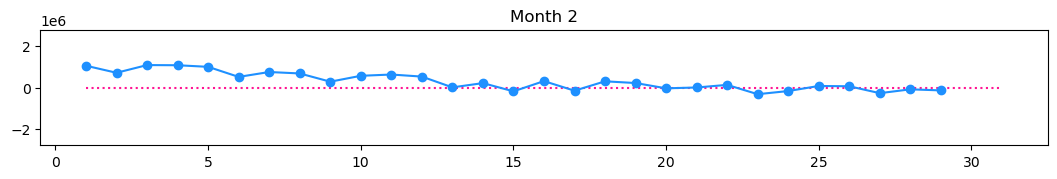

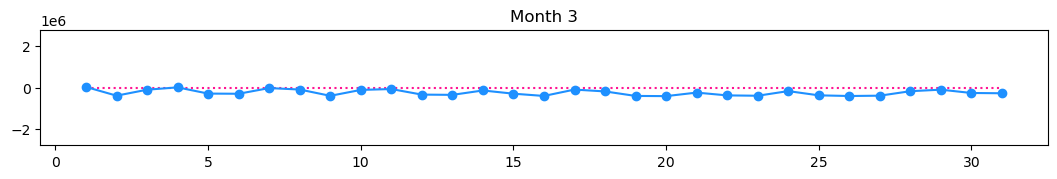

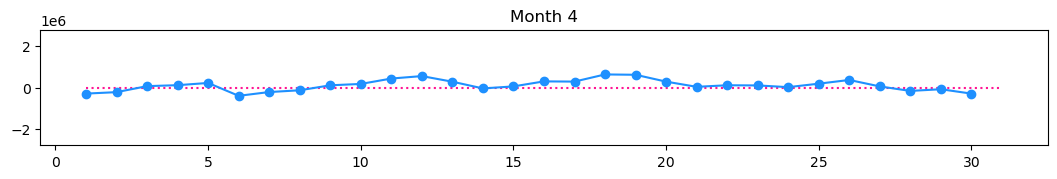

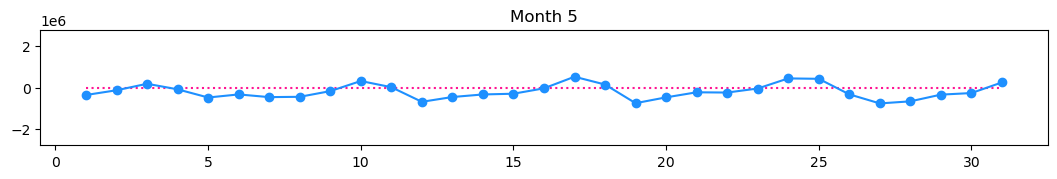

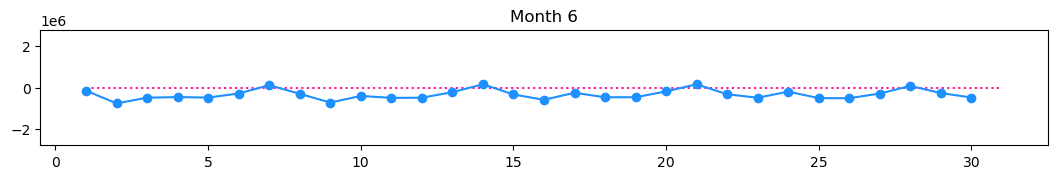

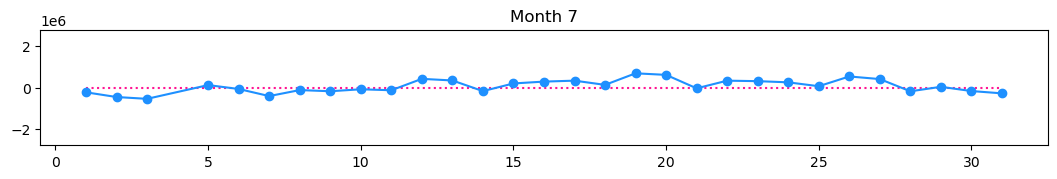

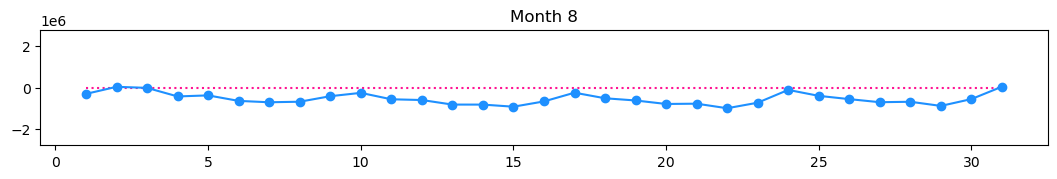

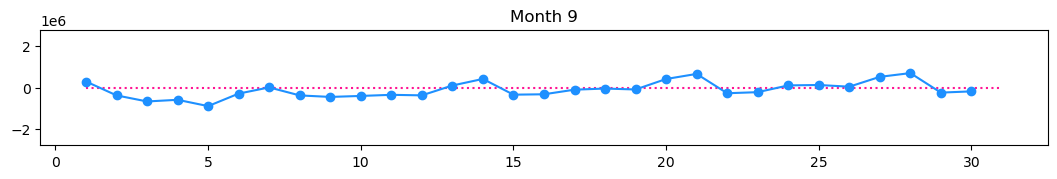

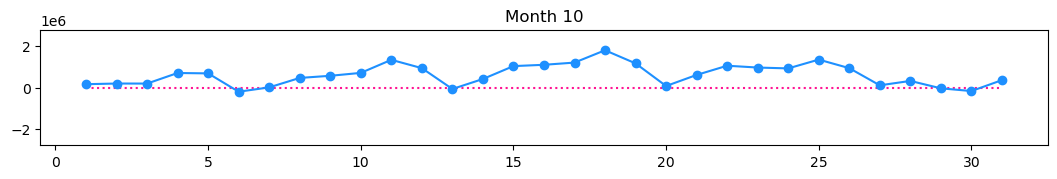

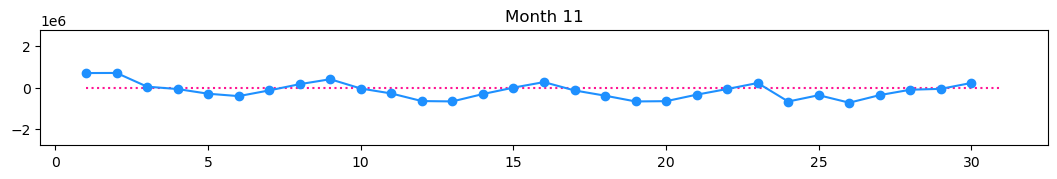

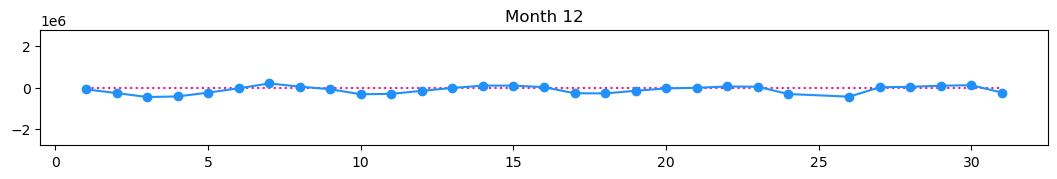

In [15]:
def plot_monthly_seasonality( df, ft, Month ): 
    A = df.loc[ df['month']==Month, ['day',ft] ].groupby('day').mean() 
    plt.figure(figsize=(13,1.5))
    plt.plot( [1,31],  [0,0], ':',  color='deeppink'   )
    plt.plot( A.index, A[ft], '-o', color='dodgerblue' )  
    YLIM = max(abs(df[ft]))
    plt.gca().set_ylim(-YLIM,+YLIM)
    plt.title('Month '+str(Month))
    plt.show()
    
for i in range(1,13):
    plot_monthly_seasonality( Seasons, 'Cyclic_Seasonality', i )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclicity

In [16]:
res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( len(res) ) 
As, ws, Tos, lags = [],[],[],[]

for i in range(20):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, To, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            if t <= To:   sig.append( 0 )
            else      :   sig.append( A * np.sin(w*(t-To)+lag) )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 4
           , size_pop  = 350 
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi,  T[-1] , 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, To, lag = Best_X
    As.append(A)
    ws.append(w)
    Tos.append(To)
    lags.append(lag)    
    print([i, Best_X, Best_y])
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[  'To' ] =  Tos
df_Cyclicity[ 'lag' ] =  lags 
df_Cyclicity

[0, array([1.09350379e+06, 3.12591729e-03, 5.80019048e+02, 5.13930810e+00]), 709577.9928713301]
[1, array([5.69691692e+05, 1.33844757e-02, 5.06285149e+02, 2.14817132e+00]), 660698.7236803819]
[2, array([2.87022807e+05, 9.75621797e-02, 5.57370577e+01, 8.41355605e-01]), 620723.5858934465]
[3, array([4.89151436e+05, 6.20883473e+00, 1.38224890e+02, 7.70983812e-01]), 594724.1603433682]
[4, array([4.21127422e+05, 7.60863190e-02, 4.66308949e+02, 5.04846713e+00]), 555907.3932443088]
[5, array([1.84189715e+05, 3.72571959e-02, 1.75612311e+02, 3.85041503e-01]), 529491.3510035777]
[6, array([3.37742379e+05, 5.77263756e-02, 7.70901676e+02, 6.19267989e+00]), 505714.39797767956]
[7, array([2.46640718e+05, 1.37679733e-02, 7.02510689e+02, 2.01466624e+00]), 492327.4089680817]
[8, array([9.95456538e+04, 1.01636841e-01, 1.25059338e+02, 6.03002901e+00]), 478781.9151861043]
[9, array([1.00013478e+05, 6.95668613e-02, 7.36146092e+00, 1.75048440e+00]), 463816.56966449035]
[10, array([9.93913418e+04, 6.08438978

,Cycle,A,w,To,lag
0,0,1.093504e+06,0.003126,580.019048,5.139308
1,1,5.696917e+05,0.013384,506.285149,2.148171
2,2,2.870228e+05,0.097562,55.737058,0.841356
3,3,4.891514e+05,6.208835,138.224890,0.770984
4,4,4.211274e+05,0.076086,466.308949,5.048467
5,5,1.841897e+05,0.037257,175.612311,0.385042
6,6,3.377424e+05,0.057726,770.901676,6.192680
7,7,2.466407e+05,0.013768,702.510689,2.014666
8,8,9.954565e+04,0.101637,125.059338,6.030029
9,9,1.000135e+05,0.069567,7.361461,1.750484


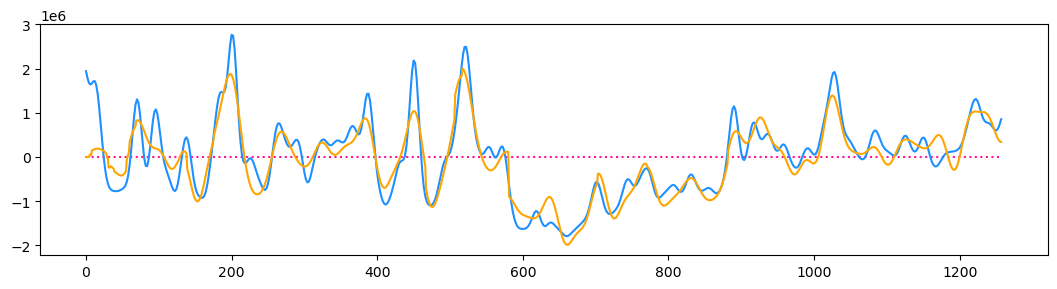

In [17]:
res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( TimeSeries.shape[0] ) 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A'  ]
    w   = df_Cyclicity.loc[i, 'w'  ]
    To  = df_Cyclicity.loc[i, 'To' ]
    lag = df_Cyclicity.loc[i, 'lag']
    sig = []
    for t in T:
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig) ]
    
plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        res , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

In [18]:
TimeSeries['Cyclicity'] = SIG
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity
2016-12-28,1153800.0,-514206.0,1668006.0,923216.503658,744789.496342,355297.818502
2016-12-29,744300.0,-971462.0,1715762.0,919618.434069,796143.565931,344331.620176
2016-12-30,1770000.0,0.0,1770000.0,916020.364480,853979.635520,340571.129016


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> continue ...

[30, array([5.87669864e+04, 1.24886377e-01, 5.62334228e+01, 3.72942743e+00]), 278323.2713859335]
[31, array([5.88610408e+04, 1.90128892e-01, 1.51624913e+02, 2.56090464e-01]), 272851.5185310896]
[32, array([4.32345040e+04, 6.13376509e+00, 6.21723625e+00, 4.18377611e+00]), 268561.9734285389]
[33, array([6.20363344e+04, 1.96648350e-01, 5.58448880e-01, 2.92714476e-01]), 260851.72508338137]
[34, array([6.06487204e+04, 3.55793943e-02, 1.12354601e+02, 5.06850487e+00]), 256665.10128682127]
[35, array([8.51818332e+04, 1.33706820e-01, 7.37343961e+01, 4.17476392e+00]), 252653.35115785457]
[36, array([5.04281294e+04, 8.51943850e-02, 8.84639812e+00, 1.69411026e+00]), 247116.12066787397]
[37, array([8.97077410e+04, 6.14574939e+00, 7.90822688e-01, 1.75676417e+00]), 240733.63984776573]
[38, array([6.09601302e+04, 2.60644497e-01, 4.19563415e+02, 5.58253535e+00]), 237620.543639245]
[39, array([5.74314044e+04, 5.98559124e+00, 2.32490940e+00, 5.29102931e+00]), 234026.2841298757]


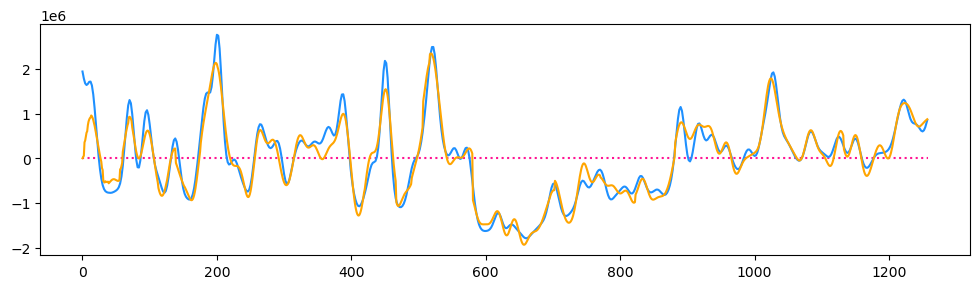

In [54]:
# input
n_Extra = 10

# auto
res  = TimeSeries['Cyclic_Seasonality'].values.copy() - TimeSeries['Cyclicity'].values.copy() 
T    = range( TimeSeries.shape[0] )
As   = df_Cyclicity[ 'A' ].values.copy().tolist()
ws   = df_Cyclicity[ 'w' ].values.copy().tolist()
Tos  = df_Cyclicity[ 'To'].values.copy().tolist()
lags = df_Cyclicity['lag'].values.copy().tolist()

for i in range( len(As), len(As)+n_Extra ):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, To, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            if t <= To:   sig.append( 0 )
            else      :   sig.append( A * np.sin(w*(t-To)+lag) )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 4
           , size_pop  = 350
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi,  T[-1] , 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, To, lag = Best_X
    As.append(A)
    ws.append(w)
    Tos.append(To)
    lags.append(lag)    
    print([i, Best_X, Best_y])
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[  'To' ] =  Tos
df_Cyclicity[ 'lag' ] =  lags

# Save & Plot
CS  = TimeSeries['Cyclic_Seasonality'].values.copy() 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A'  ]
    w   = df_Cyclicity.loc[i, 'w'  ]
    To  = df_Cyclicity.loc[i, 'To' ]
    lag = df_Cyclicity.loc[i, 'lag']
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig)  ]
    
TimeSeries['Cyclicity'] = SIG

plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        CS  , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic Trend

In [55]:
TimeSeries['Cyclic_Trend'] = TimeSeries['Trend']+TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend,Seasonality
2016-12-28,1153800.0,-514206.0,1668006.0,923216.503658,744789.496342,848450.093276,1.771667e+06,53558.482960
2016-12-29,744300.0,-971462.0,1715762.0,919618.434069,796143.565931,861133.375814,1.780752e+06,40774.650786
2016-12-30,1770000.0,0.0,1770000.0,916020.364480,853979.635520,873433.146283,1.789454e+06,31779.941632


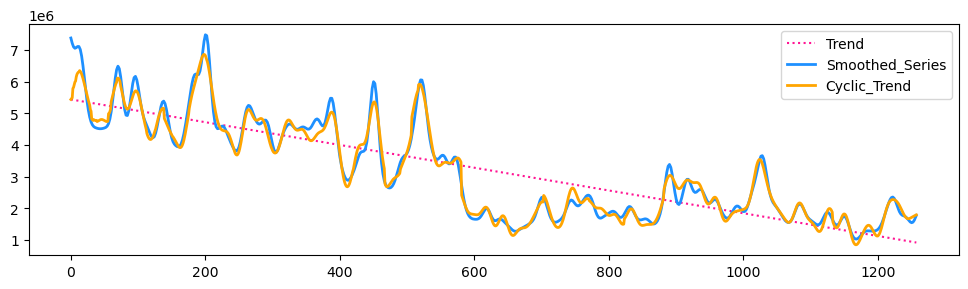

In [56]:
T = range( TimeSeries.shape[0] )
y1 = TimeSeries['Trend']
y2 = TimeSeries['Smoothed_Series']
y3 = TimeSeries['Cyclic_Trend']

plt.figure(figsize=(12,3))
plt.plot(T,y1,color='deeppink'  ,linestyle=':',label='Trend'          )
plt.plot(T,y2,color='dodgerblue',linewidth=2  ,label='Smoothed_Series')
plt.plot(T,y3,color='orange'    ,linewidth=2  ,label='Cyclic_Trend'   )
plt.legend()
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Seasonality

In [57]:
TimeSeries['Seasonality'] = TimeSeries['Cyclic_Seasonality'] - TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend,Seasonality
2016-12-28,1153800.0,-514206.0,1668006.0,923216.503658,744789.496342,848450.093276,1.771667e+06,-103660.596934
2016-12-29,744300.0,-971462.0,1715762.0,919618.434069,796143.565931,861133.375814,1.780752e+06,-64989.809883
2016-12-30,1770000.0,0.0,1770000.0,916020.364480,853979.635520,873433.146283,1.789454e+06,-19453.510763


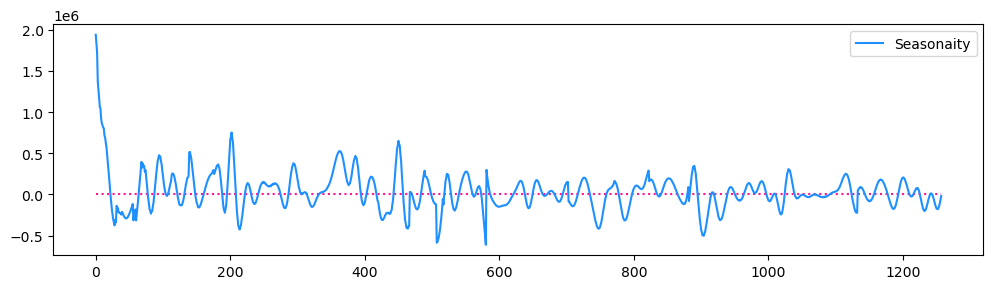

In [58]:
T = range( TimeSeries.shape[0] )
y = TimeSeries['Seasonality'] 

plt.figure(figsize=(12,3))
plt.plot([T[0],T[-1]],[0,0],color='deeppink', linestyle=':'        )
plt.plot(T,y,color='dodgerblue', linestyle='-', label='Seasonaity' )
plt.legend()
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> ARIMA

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX   # Seasonal ARIMA

import warnings
warnings.filterwarnings('ignore')

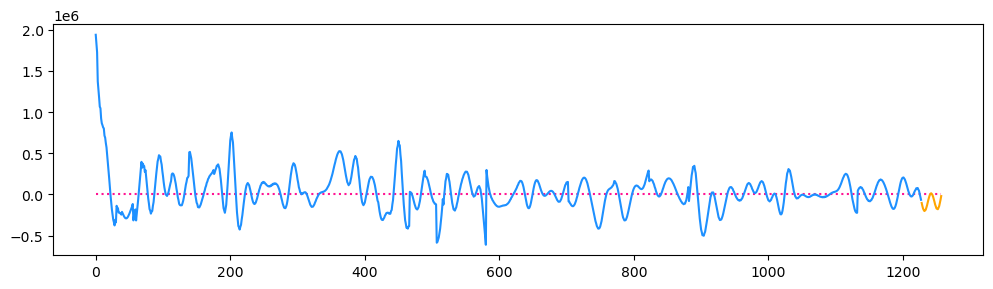

In [60]:
# input
n = 30   # n_Test

# Serie 
Series   = TimeSeries['Seasonality'].values.tolist()[:-n]
n_Series = len(Series)
T_Series = range(n_Series)

# Test
Test     = TimeSeries['Seasonality'].values.tolist()[-n:]
n_Test   = n
T_Test   = range( n_Series, n_Series+n_Test )

# Visualization
plt.figure(figsize=(12,3)); 
plt.plot( [T_Series[0],T_Test[-1]],[0,0], ":", color='deeppink' )
plt.plot( T_Series, Series, color='dodgerblue' )
plt.plot( T_Test  , Test  , color='orange'     )
plt.show()

In [61]:
from statsmodels.tsa.stattools import adfuller

print("\n\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Series )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')
else: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')



Augmented Dickey-Fuller Unit Root Test
stat=-8.842, p=0.000
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)


In [62]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Series )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)')
else: print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.535, p=0.034
Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)


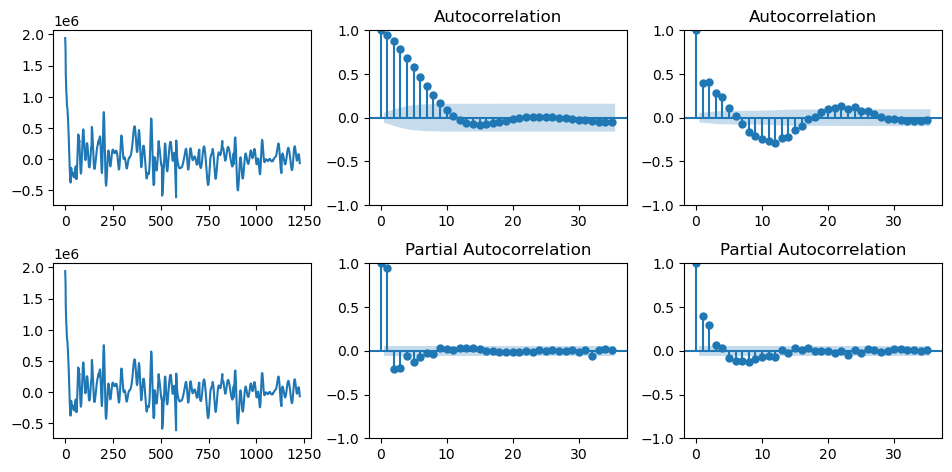

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = pd.DataFrame(Series)
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf( ts, lags=35, ax=axes[0,1] )
plot_acf( ts.diff().dropna(), lags=35, ax=axes[0,2] )
axes[1,0].plot(ts)
plot_pacf( ts, lags=35, ax=axes[1,1] )
plot_pacf( ts.diff().dropna(), lags=35, ax=axes[1,2] )
plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=(0, 0, 1.5, 1))

In [76]:
PDQs, RMSEs,AICs,BICs = [], [], [], []

n_pq = 5
for p in range(n_pq):
    for d in range(2):
        for q in range(n_pq):
            
            try:
                sarimax = SARIMAX(
                    endog                   =  Series,
                    order                   = (p,d,q),
                    seasonal_order          = (0, 0, 0, 0),
                    trend_offset            =  1,
                    trend                   =  None,   # None,'n','c','t','ct'
                    exog                    =  None,
                    dates                   =  None,
                    freq                    =  None,
                    mle_regression          =  True,
                    enforce_stationarity    =  True,
                    enforce_invertibility   =  True,
                    validate_specification  =  True,
                    time_varying_regression =  False,
                    hamilton_representation =  False, 
                    simple_differencing     =  False,
                    concentrate_scale       =  False,
                    measurement_error       =  False,
                    use_exact_diffuse       =  False,   
                    missing                 = 'none'
                    )
                model = sarimax.fit()
                
                print( 'p, d, q =', [p,d,q] )
         
                PRED    = [ x for x in model.forecast(steps=n_Test) ] 
                SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
                RMSE    =   (np.sum(SE)/n_Test)**0.5
                RMSEs.append(np.round(RMSE,1))
                
                PDQs.append( (p,d,q) )
                AICs.append(int(np.round(model.aic,-1)))
                BICs.append(int(np.round(model.bic,-1)))
        
            except:
                continue

p, d, q = [0, 0, 0]
p, d, q = [0, 0, 1]
p, d, q = [0, 0, 2]
p, d, q = [0, 0, 3]
p, d, q = [0, 0, 4]
p, d, q = [0, 0, 5]
p, d, q = [0, 0, 6]
p, d, q = [0, 0, 7]
p, d, q = [0, 0, 8]
p, d, q = [0, 0, 9]
p, d, q = [0, 1, 0]
p, d, q = [0, 1, 1]
p, d, q = [0, 1, 2]
p, d, q = [0, 1, 3]
p, d, q = [0, 1, 4]
p, d, q = [0, 1, 5]
p, d, q = [0, 1, 6]
p, d, q = [0, 1, 7]
p, d, q = [0, 1, 8]
p, d, q = [0, 1, 9]
p, d, q = [0, 2, 0]
p, d, q = [0, 2, 1]
p, d, q = [0, 2, 2]
p, d, q = [0, 2, 3]
p, d, q = [0, 2, 4]
p, d, q = [0, 2, 5]
p, d, q = [0, 2, 6]
p, d, q = [0, 2, 7]
p, d, q = [0, 2, 8]
p, d, q = [0, 2, 9]
p, d, q = [1, 0, 0]
p, d, q = [1, 0, 1]
p, d, q = [1, 0, 2]
p, d, q = [1, 0, 3]
p, d, q = [1, 0, 4]
p, d, q = [1, 0, 5]
p, d, q = [1, 0, 6]
p, d, q = [1, 0, 7]
p, d, q = [1, 0, 8]
p, d, q = [1, 0, 9]
p, d, q = [1, 1, 0]
p, d, q = [1, 1, 1]
p, d, q = [1, 1, 2]
p, d, q = [1, 1, 3]
p, d, q = [1, 1, 4]
p, d, q = [1, 1, 5]
p, d, q = [1, 1, 6]
p, d, q = [1, 1, 7]
p, d, q = [1, 1, 8]
p, d, q = [1, 1, 9]


In [77]:
df = pd.DataFrame( [RMSEs,PDQs,AICs,BICs] ).T
df.columns = ['rmse','( p, d, q )','aic','bic']
df.sort_values(['rmse','bic','aic'],ascending=[True,True,True],inplace=True)
df.head(10)

,rmse,"( p, d, q )",aic,bic
85,45496.0,"(2, 2, 5)",30010,30060
269,46948.0,"(8, 2, 9)",30030,30130
298,51543.5,"(9, 2, 8)",30040,30140
208,55650.4,"(6, 2, 8)",30030,30110
291,56698.5,"(9, 2, 1)",30010,30060
209,58677.6,"(6, 2, 9)",30040,30130
261,60010.6,"(8, 2, 1)",30020,30070
292,60776.8,"(9, 2, 2)",30010,30070
279,62456.6,"(9, 0, 9)",29860,29960
179,64117.3,"(5, 2, 9)",30040,30120


In [78]:
order = df['( p, d, q )']
order.index = range(len(order))
best_order  = order[0]
best_order

(2, 2, 5)

In [79]:
# SARIMAX
sarimax = SARIMAX(
    endog                   =  Series,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:               SARIMAX(2, 2, 5)   Log Likelihood              -14999.136
Date:                Wed, 15 Jan 2025   AIC                          30014.272
Time:                        03:19:37   BIC                          30055.164
Sample:                             0   HQIC                         30029.659
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8289      0.017    105.663      0.000       1.795       1.863
ar.L2         -0.9251      0.017    -55.858      0.000      -0.958      -0.893
ma.L1         -2.2977      0.018   -128.402      0.0

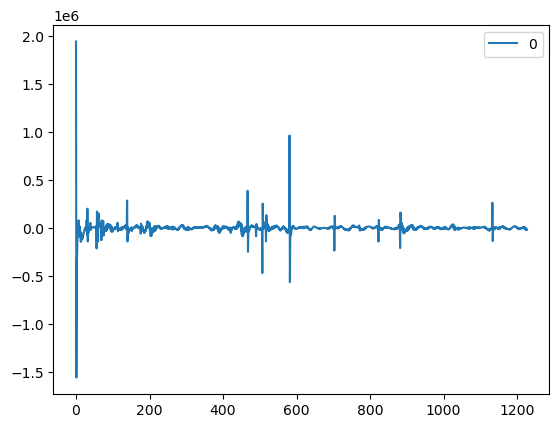

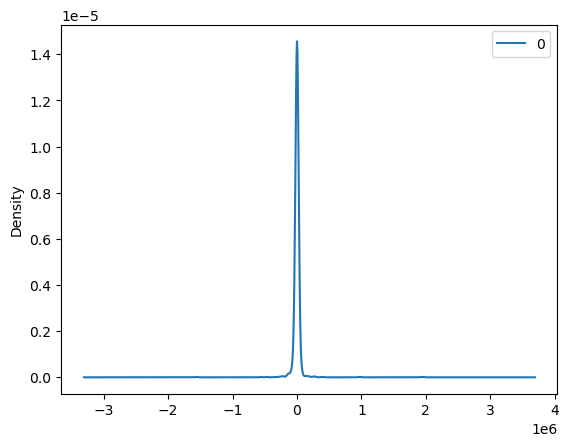

                  0
count  1.228000e+03
mean  -1.087318e+03
std    8.688567e+04
min   -1.556845e+06
25%   -1.061226e+04
50%    4.481276e+02
75%    9.583388e+03
max    1.941706e+06


In [80]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [81]:
# forcasting  
PRED    = [ x for x in model.forecast(steps=n_Test) ] 
SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
RMSE    =   (np.sum(SE)/n_Test)**0.5
RMSE

45495.9786729977

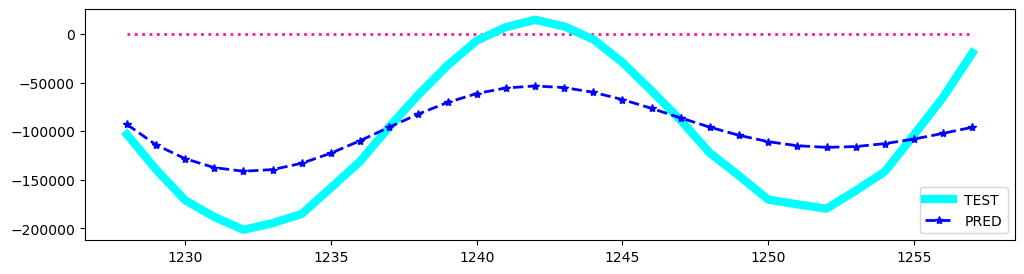

In [82]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_Test[0],T_Test[-1]], [0,0] ,  ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot(        T_Test         , Test  ,  "-"  , label="TEST" , color='cyan'     ,linewidth=6 )
plt.plot(        T_Test         , PRED  , "--*" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

#####  

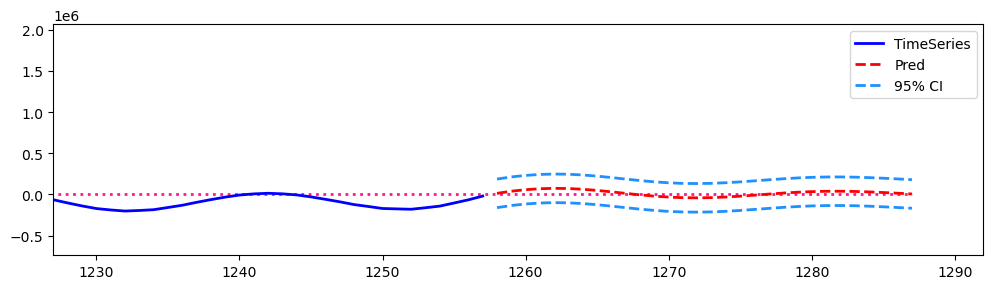

In [83]:
# input
SD      = residuals.describe().loc['std',0]
n_Steps = n_Test 

# auto
TS = Series+Test 
n_TS =  len(    TS )
T_TS = range( n_TS )

model = SARIMAX(
    endog                   =  TS,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
).fit() 

# Forecasting Unknown Future
Pred        = [ x for x in model.forecast(steps=n_Steps) ]
T_Pred      = range( n_TS, n_TS+n_Steps )

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Pred ]
Pred_68_Top = [ x+1*SD for x in Pred ] 
Pred_68_Bot = [ x-1*SD for x in Pred ] 
Pred_95_Bot = [ x-2*SD for x in Pred ]  

# Visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_TS[0],T_Pred[-1]],   [0,0]    ,  ":" , color='deeppink'  , linewidth=2                     ) 
plt.plot(          T_TS       , TS ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Pred       , "--" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-2*n_Steps, T_Pred[-1]+5 )
#plt.ylim([-12,+10])
plt.legend(); plt.show()

#####   

In [84]:
T = T_Pred
T

range(1258, 1288)

In [85]:
TREND = trend*T + initial_value
TREND 

array([912422.29489169, 908824.22530303, 905226.15571437, 901628.08612571,
       898030.01653705, 894431.94694838, 890833.87735972, 887235.80777106,
       883637.7381824 , 880039.66859374, 876441.59900508, 872843.52941642,
       869245.45982776, 865647.3902391 , 862049.32065043, 858451.25106177,
       854853.18147311, 851255.11188445, 847657.04229579, 844058.97270713,
       840460.90311847, 836862.83352981, 833264.76394114, 829666.69435248,
       826068.62476382, 822470.55517516, 818872.4855865 , 815274.41599784,
       811676.34640918, 808078.27682052])

In [86]:
SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A' ]
    w   = df_Cyclicity.loc[i, 'w' ]
    To  = df_Cyclicity.loc[i, 'To']
    lag = df_Cyclicity.loc[i,'lag']
    sig = []
    for t in T:
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig) ]
np.array(SIG)

array([ 885815.35570102,  898691.55581853,  912313.21161182,
        926675.48576621,  941441.05507232,  955893.1374768 ,
        968924.62649952,  979067.2236573 ,  984560.97568419,
        983460.95711726,  973774.30986863,  953617.77576633,
        921383.52055233,  875899.67626217,  816571.7730831 ,
        743492.14868732,  657506.46997638,  560229.53848759,
        454006.34761973,  341818.61864043,  227141.41835674,
        113758.59226922,    5549.28392051,  -93739.55234655,
       -180718.2386164 , -252560.43822647, -307174.68566393,
       -343328.23754195, -360713.55562296, -359952.00986823])

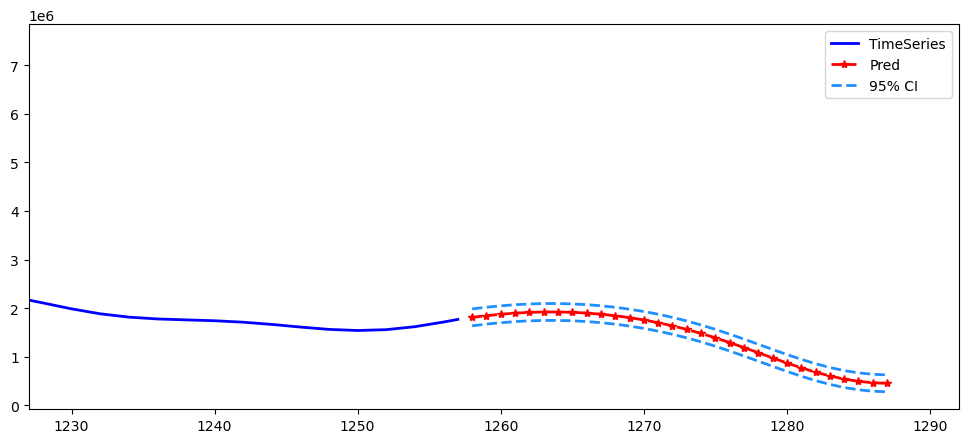

In [87]:
# Forecasting Unknown Future 
Full_Pred = [ x1+x2+x3 for x1,x2,x3 in zip(TREND,SIG,Pred) ]
#Full_Pred = [ x1+x2 for x1,x2 in zip(TREND,SIG) ]

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Full_Pred ]
Pred_68_Top = [ x+1*SD for x in Full_Pred ] 
Pred_68_Bot = [ x-1*SD for x in Full_Pred ] 
Pred_95_Bot = [ x-2*SD for x in Full_Pred ]   

# Visualizing
plt.figure( figsize=(12,5) )
plt.plot(       T_TS     , TimeSeries['Smoothed_Series'] ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Full_Pred       , "--*" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-2*n_Steps, T_Pred[-1]+5 )
#plt.ylim([760,810])
plt.legend(); plt.show()

#####   

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smoothed Series

In [133]:
# functions
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [134]:
S = TimeSeries[['Smoothed_Series']].values.astype('float32') 
S = S[:,0]
S

array([7380500., 7298565., 7216629., ..., 1668006., 1715762., 1770000.],
      dtype=float32)

In [135]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [136]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.98,1.02)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [137]:
N      = 30
nBatch = 1000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [138]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


In [ ]:
# load weights
version = 'BEST'
try:
    model.load_weights(
          Project_Name + '_' + version 
        , by_name = False 
        , skip_mismatch = False 
        , options = None 
        )
except:
    continue

In [140]:
model.compile( loss      = "mse"
             , optimizer = "adam"     # 'sgd' 'adam' 'nadam' 'adamax'
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  20
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/20
23/23 [==============================] - 20s 784ms/step - loss: 10379135549440.0000 - last_time_step_mse: 2500785602560.0000 - val_loss: 5529024331776.0000 - val_last_time_step_mse: 1155961716736.0000
Epoch 2/20
23/23 [==============================] - 19s 833ms/step - loss: 2491022835712.0000 - last_time_step_mse: 427372838912.0000 - val_loss: 1059364339712.0000 - val_last_time_step_mse: 98127388672.0000
Epoch 3/20
23/23 [==============================] - 19s 834ms/step - loss: 870431719424.0000 - last_time_step_mse: 107318312960.0000 - val_loss: 699291009024.0000 - val_last_time_step_mse: 91103297536.0000
Epoch 4/20
23/23 [==============================] - 19s 826ms/step - loss: 610732212224.0000 - last_time_step_mse: 64024649728.0000 - val_loss: 548721197056.0000 - val_last_time_step_mse: 24529108992.0000
Epoch 5/20
23/23 [==============================] - 19s 850ms/step - loss: 526516518912.0000 - last_time_step_mse: 21847474176.0000 - val_loss: 504727404544.0000 - val_l

In [141]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

4/4 [==============================] - 1s 174ms/step

RMSE = 513146.9074


In [142]:
# save weights
version = '00'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

In [143]:
# load weights
version = '00'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [144]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 0s 497ms/step


In [145]:

df_Preds = pd.DataFrame()
df_Preds['Preds'] = Preds

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

Smoothed_Preds, Noise = smoother( df_Preds, 'Preds', 3 )
Smoothed_Preds = np.round( Smoothed_Preds, 0 ) 
Smoothed_Preds# Smoothing Predictions

array([1823055., 1863885., 1904714., 1939441., 1974168., 1993331.,
       2012493., 2009009., 2005524., 1983660., 1961796., 1931743.,
       1901690., 1870117., 1838544., 1808338., 1778133., 1751882.,
       1725632., 1708720., 1691808., 1687942., 1684076., 1687195.,
       1690314., 1690378., 1690443., 1685187., 1679931., 1672851.],
      dtype=float32)

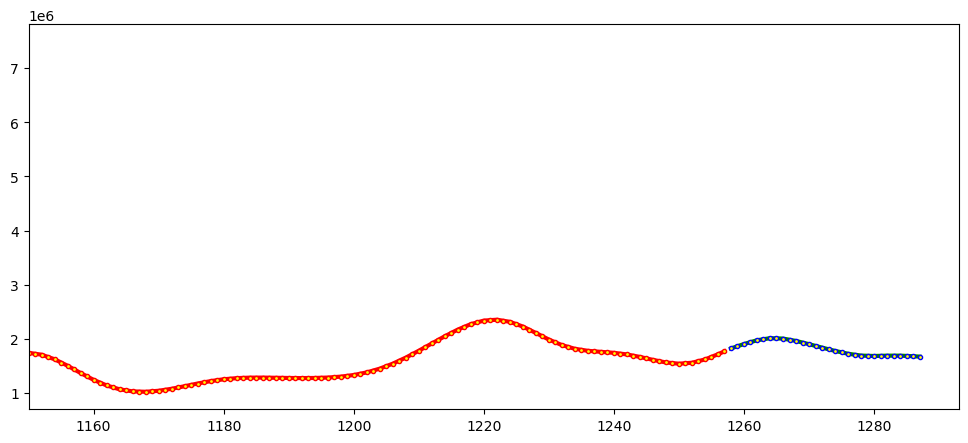

In [146]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=3
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Smoothed_Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=3
        , mec='blue', mew=1, mfc='yellow' )
#plt.xlim([-20,len(S)+N+20])
#plt.ylim([0,1300])
plt.xlim([1150,len(S)+N+5])
#plt.ylim([760,795])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

#####   

#####   

In [53]:
## save weights
#version = 'BEST'    # RMSE = 21.6
#model.save_weights( Project_Name+'_'+version, overwrite=True, save_format=None, options=None )

#####   